In [1]:
!pip install -q torchcfm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 108.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.1/58.1 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 59.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## **Dataset**

In [2]:
import torch
from torchvision import datasets, transforms

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
batch_size = 64

trainset = datasets.MNIST(
    "../data",
    train=True,
    download=True,
    transform=transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))]),
)

train_loader = torch.utils.data.DataLoader(
    trainset, batch_size=batch_size, shuffle=True, drop_last=True
)

100%|██████████| 9.91M/9.91M [00:00<00:00, 14.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 437kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.08MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.85MB/s]


## **Flow Matching**

In [3]:
from typing import Union

def pad_t_like_x(t, x):
    """Function to reshape the time vector t by the number of dimensions of x.

    Parameters
    ----------
    x : Tensor, shape (bs, *dim)
        represents the source minibatch
    t : FloatTensor, shape (bs)

    Returns
    -------
    t : Tensor, shape (bs, number of x dimensions)

    Example
    -------
    x: Tensor (bs, C, W, H)
    t: Vector (bs)
    pad_t_like_x(t, x): Tensor (bs, 1, 1, 1)
    """
    if isinstance(t, (float, int)):
        return t
    return t.reshape(-1, *([1] * (x.dim() - 1)))
class ConditionalFlowMatcher:
    """Base class for conditional flow matching methods. This class implements the independent
    conditional flow matching methods from [1] and serves as a parent class for all other flow
    matching methods.

    It implements:
    - Drawing data from gaussian probability path N(t * x1 + (1 - t) * x0, sigma) function
    - conditional flow matching ut(x1|x0) = x1 - x0
    - score function $\nabla log p_t(x|x0, x1)$
    """

    def __init__(self, sigma: Union[float, int] = 0.0):
        r"""Initialize the ConditionalFlowMatcher class. It requires the hyper-parameter $\sigma$.

        Parameters
        ----------
        sigma : Union[float, int]
        """
        self.sigma = sigma

    def compute_mu_t(self, x0, x1, t):
        """
        Compute the mean of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)

        Returns
        -------
        mean mu_t: t * x1 + (1 - t) * x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        t = pad_t_like_x(t, x0)
        return t * x1 + (1 - t) * x0

    def compute_sigma_t(self, t):
        """
        Compute the standard deviation of the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        standard deviation sigma

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t
        return self.sigma

    def sample_xt(self, x0, x1, t, epsilon):
        """
        Draw a sample from the probability path N(t * x1 + (1 - t) * x0, sigma), see (Eq.14) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        epsilon : Tensor, shape (bs, *dim)
            noise sample from N(0, 1)

        Returns
        -------
        xt : Tensor, shape (bs, *dim)

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        mu_t = self.compute_mu_t(x0, x1, t)
        sigma_t = self.compute_sigma_t(t)
        sigma_t = pad_t_like_x(sigma_t, x0)
        return mu_t + sigma_t * epsilon

    def compute_conditional_flow(self, x0, x1, t, xt):
        """
        Compute the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt

        Returns
        -------
        ut : conditional vector field ut(x1|x0) = x1 - x0

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        del t, xt
        return x1 - x0

    def sample_noise_like(self, x):
        return torch.randn_like(x)

    def sample_location_and_conditional_flow(self, x0, x1, t=None, return_noise=False):
        """
        Compute the sample xt (drawn from N(t * x1 + (1 - t) * x0, sigma))
        and the conditional vector field ut(x1|x0) = x1 - x0, see Eq.(15) [1].

        Parameters
        ----------
        x0 : Tensor, shape (bs, *dim)
            represents the source minibatch
        x1 : Tensor, shape (bs, *dim)
            represents the target minibatch
        (optionally) t : Tensor, shape (bs)
            represents the time levels
            if None, drawn from uniform [0,1]
        return_noise : bool
            return the noise sample epsilon


        Returns
        -------
        t : FloatTensor, shape (bs)
        xt : Tensor, shape (bs, *dim)
            represents the samples drawn from probability path pt
        ut : conditional vector field ut(x1|x0) = x1 - x0
        (optionally) eps: Tensor, shape (bs, *dim) such that xt = mu_t + sigma_t * epsilon

        References
        ----------
        [1] Improving and Generalizing Flow-Based Generative Models with minibatch optimal transport, Preprint, Tong et al.
        """
        if t is None:
            t = torch.rand(x0.shape[0]).type_as(x0)
        assert len(t) == x0.shape[0], "t has to have batch size dimension"

        eps = self.sample_noise_like(x0)
        xt = self.sample_xt(x0, x1, t, eps)
        ut = self.compute_conditional_flow(x0, x1, t, xt)
        if return_noise:
            return t, xt, ut, eps
        else:
            return t, xt, ut

    def compute_lambda(self, t):
        """Compute the lambda function, see Eq.(23) [3].

        Parameters
        ----------
        t : FloatTensor, shape (bs)

        Returns
        -------
        lambda : score weighting function

        References
        ----------
        [4] Simulation-free Schrodinger bridges via score and flow matching, Preprint, Tong et al.
        """
        sigma_t = self.compute_sigma_t(t)
        return 2 * sigma_t / (self.sigma**2 + 1e-8)

## **Training**

### **Advanced UNet Model**

In [4]:
from torchcfm.models.unet import UNetModel

In [5]:
# sigma = 0.0
model = UNetModel(
    dim=(1, 28, 28), num_channels=32, num_res_blocks=1, num_classes=10, class_cond=True
).to(device)

# FM = ConditionalFlowMatcher(sigma=sigma)
optimizer = torch.optim.Adam(model.parameters())

In [6]:
n_epochs = 10 #1000

for epoch in range(n_epochs):
    losses = []
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1).to(device)
        t = torch.rand(1).to(device)  # Random time step t
        xt = t * x1 + (1 - t) * x0  # Interpolated data point
        ut = x1 - x0  # True difference (velocity)

        # Model prediction
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

epoch: 0, loss: 0.288
epoch: 1, loss: 0.2035
epoch: 2, loss: 0.1881
epoch: 3, loss: 0.1847
epoch: 4, loss: 0.1822
epoch: 5, loss: 0.1772
epoch: 6, loss: 0.1773
epoch: 7, loss: 0.1769
epoch: 8, loss: 0.171
epoch: 9, loss: 0.1724


In [7]:
def euler_method(model, x, t_steps, dt, generated_class_list=None):
    y = x
    y_values = [y]  # Store the initial value

    for t in t_steps[1:]:
        dy = model(t, y, generated_class_list)
        y = y + dy * dt  # Euler update step
        y_values.append(y)

    return torch.stack(y_values)

# Initial random image and class (optional)
initial_image = torch.randn(100, 1, 28, 28, device=device)
generated_class_list = torch.randint(0, 10, (100,), device=device)

# Time parameters
t_steps = torch.linspace(0, 1, 2, device=device)
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, initial_image, t_steps, dt, generated_class_list)

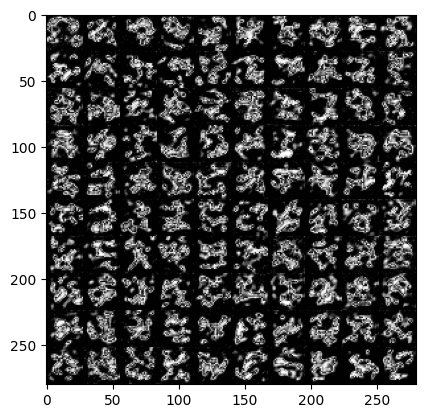

In [8]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()

### **Base Model**

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Simple U-Net with time and class embedding
class SimpleUNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, base_channels=32, time_embed_dim=32, num_classes=10):
        super(SimpleUNet, self).__init__()

        # Time embedding (using a simple linear layer)
        self.time_embedding = nn.Linear(1, time_embed_dim)

        # Class embedding (using nn.Embedding)
        self.class_embedding = nn.Embedding(num_classes, time_embed_dim)  # Embedding to the same dimension as time

        # Encoder: 2 convolutional layers
        self.encoder1 = nn.Conv2d(in_channels + time_embed_dim, base_channels, kernel_size=3, padding=1)
        self.encoder2 = nn.Conv2d(base_channels, base_channels * 2, kernel_size=3, padding=1)

        # Decoder: 2 transposed convolutional layers
        self.decoder1 = nn.ConvTranspose2d(base_channels * 2, base_channels, kernel_size=3, padding=1)
        self.decoder2 = nn.ConvTranspose2d(base_channels, out_channels, kernel_size=3, padding=1)

    def forward(self, t, x, y=None):
        # Get time embedding
        t_emb = F.relu(self.time_embedding(t.unsqueeze(-1)))  # Shape: (batch_size, time_embed_dim)

        # Get class embedding (only if class labels are provided)
        if y is not None:
            y_emb = self.class_embedding(y)  # Shape: (batch_size, time_embed_dim)
            embedding = t_emb + y_emb  # Shape: (batch_size, time_embed_dim) + (batch_size, base_channels)
        else:
            embedding = t_emb  # Shape: (batch_size, time_embed_dim)

        # Expand time and class embeddings to match spatial dimensions (HxW)
        embedding = embedding.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, x.size(2), x.size(3))  # Shape: (batch_size, time_embed_dim, H, W)

        # Concatenate time and class embeddings with the input image
        x = torch.cat([x, embedding], dim=1)  # Shape: (batch_size, in_channels + time_embed_dim, H, W)

        # Encoder: 2 convolutional layers
        x = F.relu(self.encoder1(x))  # Shape: (batch_size, base_channels, H, W)
        x = F.relu(self.encoder2(x))  # Shape: (batch_size, base_channels*2, H, W)

        # Decoder: 2 transposed convolutional layers
        x = F.relu(self.decoder1(x))  # Shape: (batch_size, base_channels, H, W)
        out = self.decoder2(x)  # Shape: (batch_size, out_channels, H, W)

        return out

In [10]:
sigma = 0.0
model = SimpleUNet(
    in_channels=1, out_channels=1, base_channels=32, time_embed_dim=32, num_classes=10
).to(device)

FM = ConditionalFlowMatcher(sigma=sigma)
optimizer = torch.optim.Adam(model.parameters())

In [11]:
n_epochs = 100
for epoch in range(n_epochs):
    losses = []
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

epoch: 0, loss: 0.4126
epoch: 1, loss: 0.2823
epoch: 2, loss: 0.2712
epoch: 3, loss: 0.2626
epoch: 4, loss: 0.2573
epoch: 5, loss: 0.2539
epoch: 6, loss: 0.2504
epoch: 7, loss: 0.2493
epoch: 8, loss: 0.2464
epoch: 9, loss: 0.2453
epoch: 10, loss: 0.2441
epoch: 11, loss: 0.2434
epoch: 12, loss: 0.2422
epoch: 13, loss: 0.2411
epoch: 14, loss: 0.2403
epoch: 15, loss: 0.2418
epoch: 16, loss: 0.2391
epoch: 17, loss: 0.2377
epoch: 18, loss: 0.2389
epoch: 19, loss: 0.2377
epoch: 20, loss: 0.2371
epoch: 21, loss: 0.2378
epoch: 22, loss: 0.2363
epoch: 23, loss: 0.2366
epoch: 24, loss: 0.2351
epoch: 25, loss: 0.2343
epoch: 26, loss: 0.2354
epoch: 27, loss: 0.2344
epoch: 28, loss: 0.2339
epoch: 29, loss: 0.2338
epoch: 30, loss: 0.2331
epoch: 31, loss: 0.2324
epoch: 32, loss: 0.2326
epoch: 33, loss: 0.2324
epoch: 34, loss: 0.2322
epoch: 35, loss: 0.231
epoch: 36, loss: 0.2317
epoch: 37, loss: 0.2324
epoch: 38, loss: 0.2314
epoch: 39, loss: 0.2304
epoch: 40, loss: 0.2305
epoch: 41, loss: 0.2314
epo

In [12]:
for epoch in range(n_epochs):
    losses = []
    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        x1 = data[0].to(device)
        y = data[1].to(device)
        x0 = torch.randn_like(x1)
        t, xt, ut = FM.sample_location_and_conditional_flow(x0, x1)
        vt = model(t, xt, y)
        loss = torch.mean((vt - ut) ** 2)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    avg_loss = sum(losses) / len(losses)
    print(f"epoch: {epoch}, loss: {avg_loss:.4}")

epoch: 0, loss: 0.2247
epoch: 1, loss: 0.2258
epoch: 2, loss: 0.2246
epoch: 3, loss: 0.2247
epoch: 4, loss: 0.2248
epoch: 5, loss: 0.225
epoch: 6, loss: 0.2239
epoch: 7, loss: 0.2237
epoch: 8, loss: 0.2246
epoch: 9, loss: 0.2239
epoch: 10, loss: 0.2238
epoch: 11, loss: 0.2247
epoch: 12, loss: 0.2243
epoch: 13, loss: 0.2245
epoch: 14, loss: 0.2241
epoch: 15, loss: 0.2235
epoch: 16, loss: 0.2241
epoch: 17, loss: 0.2248
epoch: 18, loss: 0.2237
epoch: 19, loss: 0.2237
epoch: 20, loss: 0.2241
epoch: 21, loss: 0.2244
epoch: 22, loss: 0.2226
epoch: 23, loss: 0.2243
epoch: 24, loss: 0.2231
epoch: 25, loss: 0.224
epoch: 26, loss: 0.2234
epoch: 27, loss: 0.2237
epoch: 28, loss: 0.2238
epoch: 29, loss: 0.2227
epoch: 30, loss: 0.2238
epoch: 31, loss: 0.2237
epoch: 32, loss: 0.2238
epoch: 33, loss: 0.2237
epoch: 34, loss: 0.2236
epoch: 35, loss: 0.2231
epoch: 36, loss: 0.2239
epoch: 37, loss: 0.2239
epoch: 38, loss: 0.2236
epoch: 39, loss: 0.2236
epoch: 40, loss: 0.2237
epoch: 41, loss: 0.2237
epoc

In [14]:
def euler_method(model, x, t_steps, dt, generated_class_list=None):
    y = x
    y_values = [y]  # Store the initial value

    for t in t_steps[1:]:
        dy = model(t, y, generated_class_list)  # Compute the derivative (model output)
        y = y + dy * dt  # Euler update step
        y_values.append(y)

    return torch.stack(y_values)

# Initial random image and class (optional)
initial_image = torch.randn(100, 1, 28, 28, device=device)  # Batch size 100, 1 channel, 28x28 image
generated_class_list = torch.randint(0, 10, (100,), device=device)  # Random class labels for conditioning (optional)

# Time parameters
t_steps = torch.linspace(0, 1, 2, device=device)  # Two time steps from 0 to 1
dt = t_steps[1] - t_steps[0]  # Time step

# Solve the ODE using Euler method
traj = euler_method(model, initial_image, t_steps, dt, generated_class_list)

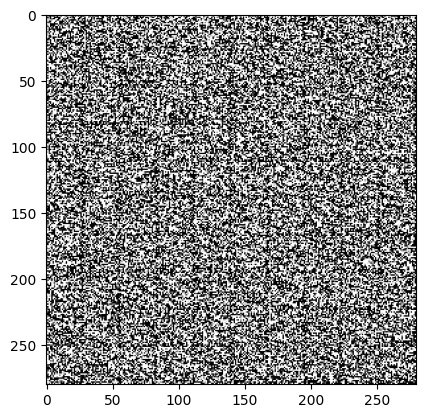

In [15]:
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage
from torchvision.utils import make_grid

grid = make_grid(
    traj[-1, :100].view([-1, 1, 28, 28]).clip(-1, 1), value_range=(-1, 1), padding=0, nrow=10
)
img = ToPILImage()(grid)
plt.imshow(img)
plt.show()